In [1]:
from PIL import Image, ImageOps
import io
import numpy as np
from matplotlib import pyplot as plt
from package.utils.logger import logger
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import transforms
from torchvision.models import VGG16_Weights

import pickle

from sklearn.metrics import accuracy_score, precision_score, adjusted_rand_score

import pandas as pd
from IPython.display import display

# Initialing compute device (use GPU if available).
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image


# Load the dataset
raw_dataset = np.load(".ds.tiny/dataset.zip", allow_pickle=True)

dataset = {
    "train": {
        "data": [],
        "names": [],
        "labels": [],
        "unique_labels": [],
    },
    "valid": {
        "data": [],
        "names": [],
        "labels": [],
        "unique_labels": [],
    },
}

images_shape = (224, 224)

# For each image we have the path from which we extract the name and the label of the image
for dsKey in raw_dataset.keys():
    splittedKey = dsKey.split("/")

    img_type = splittedKey[2]
    img_label = splittedKey[3]
    img_name = splittedKey[4]

    img = Image.open(io.BytesIO(raw_dataset[dsKey]))
    img = ImageOps.fit(img, images_shape, Image.Resampling.LANCZOS).convert("RGB")

    img_array = np.asarray(img)

    dataset[img_type]["data"].append(img_array)
    dataset[img_type]["names"].append(img_name)
    dataset[img_type]["labels"].append(img_label)

for img_type in dataset.keys():
    dataset[img_type]["data"] = np.asarray(dataset[img_type]["data"])
    dataset[img_type]["names"] = np.asarray(dataset[img_type]["names"])

    dataset[img_type]["unique_labels"], dataset[img_type]["labels"] = np.unique(
        np.asarray(dataset[img_type]["labels"]), return_inverse=True
    )

In [3]:
normalization_std = [0.229, 0.224, 0.225]
normalization_mean = [0.485, 0.456, 0.406]

loader = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224),
        transforms.Normalize(mean=normalization_mean, std=normalization_std),
    ]
)

vgg_out = {"train": [], "valid": []}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features.to(device)

for img_type in dataset.keys():
    vgg_out[img_type] = []

    for image_idx in range(dataset[img_type]["data"].shape[0]):
        loaded_image = (
            loader(dataset[img_type]["data"][image_idx, :]).unsqueeze(0).to(device)
        )

        with torch.no_grad():
            res = model(loaded_image)
        features = res.data.detach().cpu().numpy().flatten()
        print(f"Extracting feature: {image_idx}/{dataset[img_type]['data'].shape[0]}")

        vgg_out[img_type].append(features)

    vgg_out[img_type] = np.asarray(vgg_out[img_type])
    print(vgg_out[img_type].shape)

pickle.dump(vgg_out, open("vgg_out.pkl", "wb"))

Extracting feature: 0/1500
Extracting feature: 1/1500
Extracting feature: 2/1500
Extracting feature: 3/1500
Extracting feature: 4/1500
Extracting feature: 5/1500
Extracting feature: 6/1500
Extracting feature: 7/1500
Extracting feature: 8/1500
Extracting feature: 9/1500
Extracting feature: 10/1500
Extracting feature: 11/1500
Extracting feature: 12/1500
Extracting feature: 13/1500
Extracting feature: 14/1500
Extracting feature: 15/1500
Extracting feature: 16/1500
Extracting feature: 17/1500
Extracting feature: 18/1500
Extracting feature: 19/1500
Extracting feature: 20/1500
Extracting feature: 21/1500
Extracting feature: 22/1500
Extracting feature: 23/1500
Extracting feature: 24/1500
Extracting feature: 25/1500
Extracting feature: 26/1500
Extracting feature: 27/1500
Extracting feature: 28/1500
Extracting feature: 29/1500
Extracting feature: 30/1500
Extracting feature: 31/1500
Extracting feature: 32/1500
Extracting feature: 33/1500
Extracting feature: 34/1500
Extracting feature: 35/1500
Ex

In [4]:
# preload env
vgg_out = pickle.load(open("vgg_out.pkl", "rb"))

# Dimensionality reduction

n_components_to_test = {
    "PCA": [3, 10, 50, 100, 200, 500, 1200],
    "LDA": [3, 5, 7, 9],
    "TSNE": [2, 3],
}

PCAs_instances = {}
LDAs_instances = {}
TSNEs_instances = {}

PCAs_results = {
    "train": {},
    "valid": {},
}

LDAs_results = {
    "train": {},
    "valid": {},
}

TSNEs_results = {
    "train": {},
    "valid": {},
}

for n_components in n_components_to_test["PCA"]:
    PCAs_instances[n_components] = []

    PCAs_results["train"][n_components] = []
    PCAs_results["valid"][n_components] = []

    PCA_instance = PCA(n_components=n_components)

    PCA_instance.fit(vgg_out["train"])

    PCAs_results["train"][n_components] = PCA_instance.transform(vgg_out["train"])
    PCAs_results["valid"][n_components] = PCA_instance.transform(vgg_out["valid"])

    PCAs_instances[n_components] = PCA_instance

    logger.info(
        [
            f"PCA ({n_components} components): explained_variance_ratio sum",
            np.sum(PCA_instance.explained_variance_ratio_, axis=0),
        ]
    )


for n_components in n_components_to_test["LDA"]:

    LDAs_instances[n_components] = []

    LDAs_results["train"][n_components] = []
    LDAs_results["valid"][n_components] = []

    LDA_instance = LinearDiscriminantAnalysis(n_components=n_components)

    LDA_instance.fit(vgg_out["train"], dataset["train"]["labels"])

    LDAs_results["train"][n_components] = LDA_instance.transform(vgg_out["train"])
    LDAs_results["valid"][n_components] = LDA_instance.transform(vgg_out["valid"])

    LDAs_instances[n_components] = LDA_instance

    logger.info(
        [
            f"LDA ({n_components} components): explained_variance_ratio sum",
            np.sum(LDA_instance.explained_variance_ratio_, axis=0),
        ]
    )

for n_components in n_components_to_test["TSNE"]:

    TSNEs_instances[n_components] = []

    TSNEs_results["train"][n_components] = []
    # TSNEs_results['valid'][n_components] = []

    TSNE_instance_train = TSNE(n_components=n_components, verbose=1, n_iter=3000)
    TSNE_instance_valid = TSNE(n_components=n_components, verbose=1, n_iter=3000)

    # TSNEs_results['train'][n_components] = TSNE_instance_train.fit_transform(vgg_out['train'])
    # TSNEs_results['valid'][n_components] = TSNE_instance_valid.fit_transform(vgg_out['valid'])

    TSNEs_results["train"][n_components] = TSNE_instance_train.fit_transform(
        LDAs_results["train"][7]
    )
    TSNEs_results["valid"][n_components] = TSNE_instance_valid.fit_transform(
        LDAs_results["valid"][7]
    )

    TSNEs_instances[n_components] = [TSNE_instance_train, TSNE_instance_valid]

    # logger.info([f'TSNE ({n_components} components): explained_variance_ratio sum', np.sum(TSNE_instance[1].explained_variance_ratio_,axis=0)])

DEFAULT_LOGGER: 2024-07-02 17:53:08,930 | INFO | 4128527992.py:46 ['PCA (3 components): explained_variance_ratio sum', 0.05650963]
DEFAULT_LOGGER: 2024-07-02 17:53:15,178 | INFO | 4128527992.py:46 ['PCA (10 components): explained_variance_ratio sum', 0.11163047]


KeyboardInterrupt: 

(150, 2)
(150, 2)
(150, 2)
(150, 2)
(150, 2)
(150, 2)
(150, 2)
(150, 2)
(150, 2)
(150, 2)


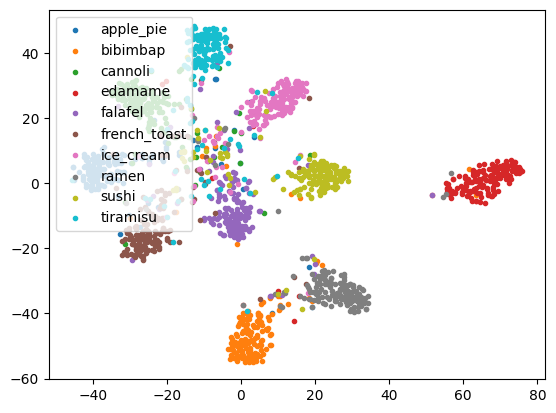

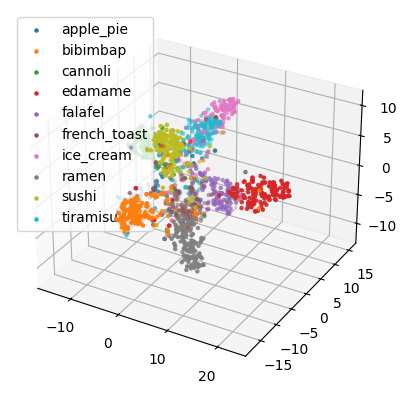

In [33]:
fig_2d = plt.figure()
ax = fig_2d.add_subplot()

for i in range(len(dataset["train"]["unique_labels"])):
    classIdxs = dataset["train"]["labels"] == i

    tsne_features = TSNEs_results["train"][2][classIdxs, :]

    print(tsne_features.shape)

    ax.set_label(dataset["train"]["unique_labels"][i])
    ax.scatter(
        tsne_features[:, 0],
        tsne_features[:, 1],
        marker=".",
        label=dataset["train"]["unique_labels"][i],
    )
plt.legend(loc="upper left")

fig_3d = plt.figure()
ax = fig_3d.add_subplot(projection="3d")
for i in range(len(dataset["train"]["unique_labels"])):
    classIdxs = dataset["train"]["labels"] == i

    tsne_features = TSNEs_results["train"][3][classIdxs, :]

    ax.scatter(
        tsne_features[:, 0],
        tsne_features[:, 1],
        tsne_features[:, 2],
        marker=".",
        label=dataset["train"]["unique_labels"][i],
    )

plt.legend(loc="upper left")
plt.show()

c:\Users\luca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

,k\VGG,
0,3,"(0.242, 0.474)"
1,5,"(0.246, 0.543)"
2,9,"(0.278, 0.494)"
3,15,"(0.27, 0.541)"
4,21,"(0.238, 0.612)"
5,55,"(0.208, 0.527)"
6,111,"(0.196, 0.297)"
7,251,"(0.196, 0.178)"


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

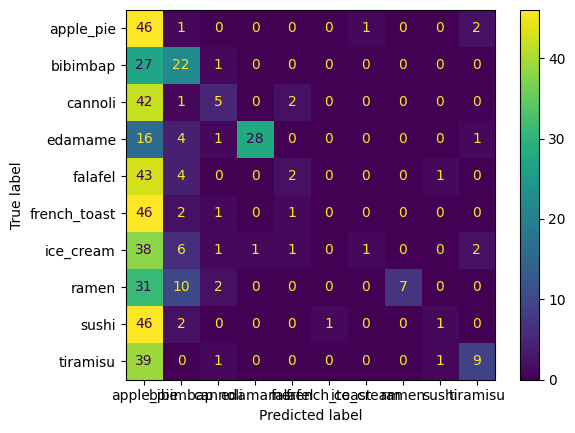

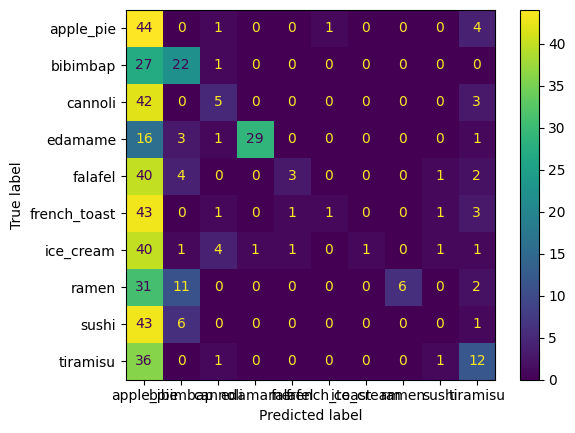

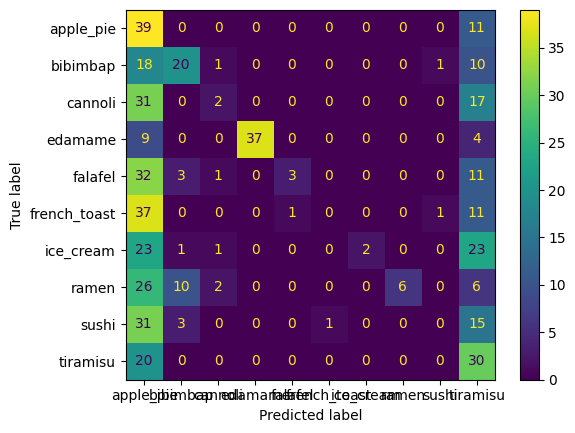

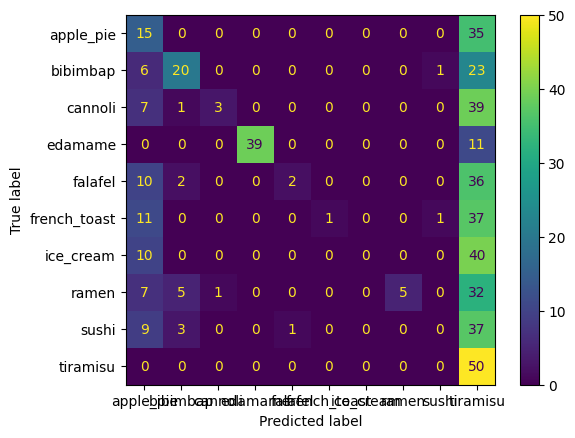

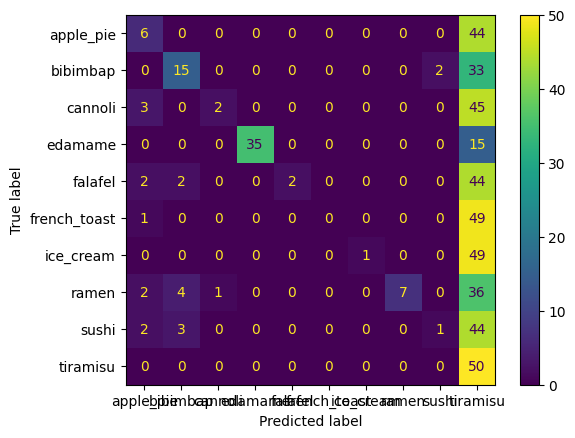

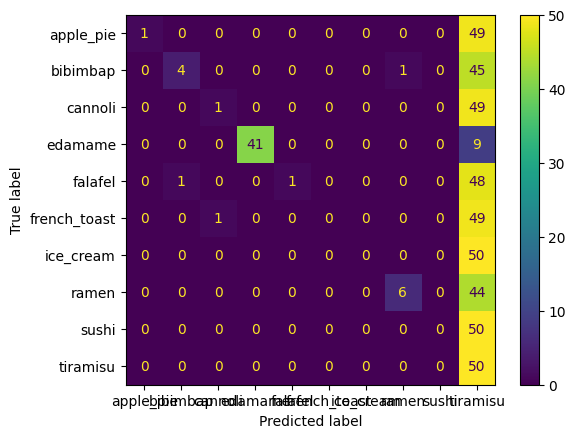

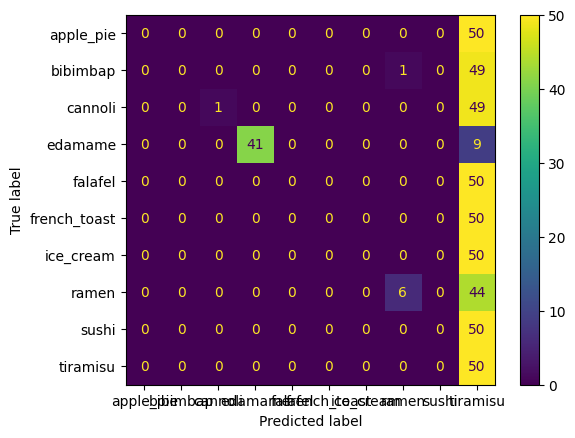

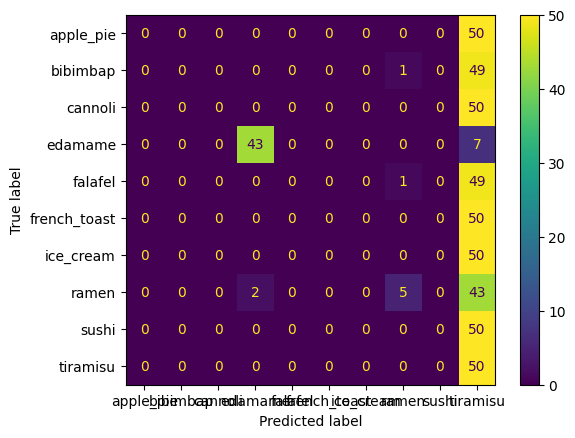

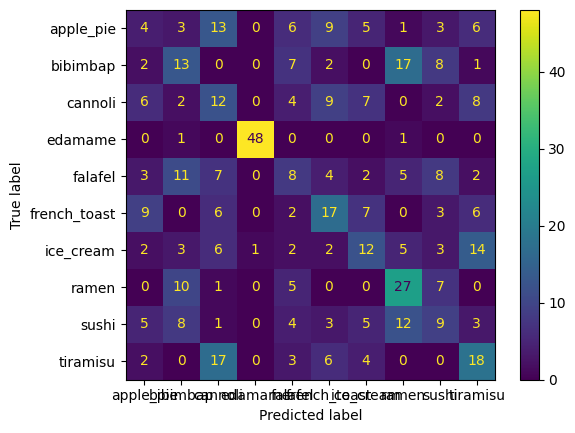

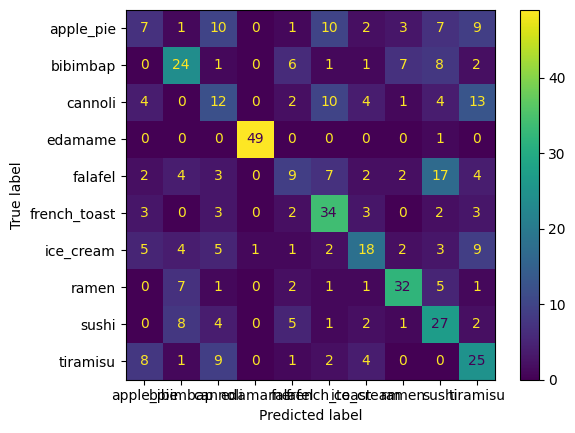

In [7]:
# Classification - KNN

k_to_test = {
    "VGG": [3, 5, 9, 15, 21, 55, 111, 251],
    "PCA": [3, 5, 9, 15, 21, 55, 111, 251],
    "LDA": [3, 5, 9, 15, 21, 55, 111, 251],
}

KNN_VGG_stats = []
KNN_PCA_stats = []
KNN_LDA_stats = []

for k_idx, k in enumerate(k_to_test["VGG"]):

    KNN_VGG_stats.insert(k_idx, [k])

    knn = KNeighborsClassifier(k)

    knn.fit(vgg_out["train"], dataset["train"]["labels"])
    preds = knn.predict(vgg_out["valid"])

    accuracy = round(accuracy_score(dataset["valid"]["labels"], preds), 3)
    precision = round(
        precision_score(dataset["valid"]["labels"], preds, average="macro"), 3
    )

    KNN_VGG_stats[k_idx].append((accuracy, precision))

    # ConfusionMatrixDisplay(confusion_matrix(dataset['valid']['labels'], preds),display_labels=dataset['valid']['unique_labels']).plot()

KNN_VGG_df = pd.DataFrame(KNN_VGG_stats, columns=["k\\VGG", ""])
display(KNN_VGG_df)

for k_idx, k in enumerate(k_to_test["PCA"]):

    KNN_PCA_stats.insert(k_idx, [k])

    for n_components_idx, n_components in enumerate(n_components_to_test["PCA"]):
        knn = OneVsOneClassifier(KNeighborsClassifier(k))

        knn.fit(PCAs_results["train"][n_components], dataset["train"]["labels"])
        preds = knn.predict(PCAs_results["valid"][n_components])

        accuracy = round(accuracy_score(dataset["valid"]["labels"], preds), 3)
        precision = round(
            precision_score(dataset["valid"]["labels"], preds, average="macro"), 3
        )

        KNN_PCA_stats[k_idx].insert(n_components_idx + 1, (accuracy, precision))

        # ConfusionMatrixDisplay(confusion_matrix(dataset['valid']['labels'], preds),display_labels=dataset['valid']['unique_labels']).plot()

KNN_PCA_df = pd.DataFrame(
    KNN_PCA_stats, columns=["k\\PCA components"] + n_components_to_test["PCA"]
)
display(KNN_PCA_df)

for k_idx, k in enumerate(k_to_test["LDA"]):

    KNN_LDA_stats.insert(k_idx, [k])

    for n_components_idx, n_components in enumerate(n_components_to_test["LDA"]):
        knn = OneVsOneClassifier(KNeighborsClassifier(k))

        knn.fit(LDAs_results["train"][n_components], dataset["train"]["labels"])
        preds = knn.predict(LDAs_results["valid"][n_components])

        accuracy = round(accuracy_score(dataset["valid"]["labels"], preds), 3)
        precision = round(
            precision_score(dataset["valid"]["labels"], preds, average="macro"), 3
        )

        KNN_LDA_stats[k_idx].insert(n_components_idx + 1, (accuracy, precision))
        # ConfusionMatrixDisplay(confusion_matrix(dataset['valid']['labels'], preds),display_labels=dataset['valid']['unique_labels']).plot()


KNN_LDA_df = pd.DataFrame(
    KNN_LDA_stats, columns=["k\\LDA components"] + n_components_to_test["LDA"]
)
display(KNN_LDA_df)

plt.show()

In [35]:
# Classification - SVM

kernels_to_test = {
    "PCA": ["linear", "poly", "sigmoid"], 
    "LDA": ["linear", "poly", "sigmoid"], 
    "TSNE": ["linear", "poly", "sigmoid"], 
}

SVM_PCA_stats = []
SVM_LDA_stats = []
SVM_TSNE_stats = []

for kernel_idx, kernel in enumerate(kernels_to_test["PCA"]):

    SVM_PCA_stats.insert(kernel_idx, [kernel])

    for n_components_idx, n_components in enumerate(
        n_components_to_test["PCA"]
    ):  # n_components_to_test['PCA']):
        svm = OneVsOneClassifier(SVC(kernel=kernel))

        svm.fit(PCAs_results["train"][n_components], dataset["train"]["labels"])

        preds = svm.predict(PCAs_results["valid"][n_components])

        accuracy = round(accuracy_score(dataset["valid"]["labels"], preds), 3)
        precision = round(
            precision_score(dataset["valid"]["labels"], preds, average="macro"), 3
        )

        SVM_PCA_stats[kernel_idx].insert(n_components_idx + 1, (accuracy, precision))

SVM_PCA_df = pd.DataFrame(
    SVM_PCA_stats, columns=["kernel\\PCA components"] + n_components_to_test["PCA"]
)
display(SVM_PCA_df)

for kernel_idx, kernel in enumerate(kernels_to_test["LDA"]):

    SVM_LDA_stats.insert(kernel_idx, [kernel])

    for n_components_idx, n_components in enumerate(n_components_to_test["LDA"]):
        svm = OneVsOneClassifier(SVC(kernel=kernel))

        svm.fit(LDAs_results["train"][n_components], dataset["train"]["labels"])

        preds = svm.predict(LDAs_results["valid"][n_components])

        accuracy = round(accuracy_score(dataset["valid"]["labels"], preds), 3)
        precision = round(
            precision_score(dataset["valid"]["labels"], preds, average="macro"), 3
        )

        SVM_LDA_stats[kernel_idx].insert(n_components_idx + 1, (accuracy, precision))

SVM_LDA_df = pd.DataFrame(
    SVM_LDA_stats, columns=["kernel\\LDA components"] + n_components_to_test["LDA"]
)
display(SVM_LDA_df)

for kernel_idx, kernel in enumerate(kernels_to_test["TSNE"]):

    SVM_TSNE_stats.insert(kernel_idx, [kernel])

    for n_components_idx, n_components in enumerate(n_components_to_test["TSNE"]):
        svm = OneVsOneClassifier(SVC(kernel=kernel))

        svm.fit(TSNEs_results["train"][n_components], dataset["train"]["labels"])

        preds = svm.predict(TSNEs_results["valid"][n_components])

        accuracy = round(accuracy_score(dataset["valid"]["labels"], preds), 3)
        precision = round(
            precision_score(dataset["valid"]["labels"], preds, average="macro"), 3
        )

        SVM_TSNE_stats[kernel_idx].insert(n_components_idx + 1, (accuracy, precision))

SVM_TSNE_df = pd.DataFrame(
    SVM_TSNE_stats, columns=["kernel\\TSNE components"] + n_components_to_test["TSNE"]
)
display(SVM_TSNE_df)

c:\Users\luca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,kernel\PCA components,3,10,50,100,200,500,1200
0,linear,"(0.378, 0.36)","(0.59, 0.585)","(0.682, 0.683)","(0.672, 0.672)","(0.698, 0.697)","(0.718, 0.72)","(0.726, 0.727)"
1,poly,"(0.324, 0.363)","(0.506, 0.572)","(0.494, 0.709)","(0.342, 0.759)","(0.236, 0.825)","(0.172, 0.586)","(0.162, 0.411)"
2,sigmoid,"(0.302, 0.318)","(0.494, 0.489)","(0.724, 0.726)","(0.752, 0.754)","(0.748, 0.753)","(0.75, 0.756)","(0.762, 0.771)"


,kernel\LDA components,3,5,7,9
0,linear,"(0.444, 0.482)","(0.604, 0.617)","(0.638, 0.639)","(0.622, 0.625)"
1,poly,"(0.396, 0.491)","(0.488, 0.631)","(0.478, 0.66)","(0.474, 0.714)"
2,sigmoid,"(0.402, 0.379)","(0.54, 0.54)","(0.604, 0.6)","(0.638, 0.646)"


c:\Users\luca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\luca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,kernel\TSNE components,2,3
0,linear,"(0.244, 0.266)","(0.306, 0.394)"
1,poly,"(0.154, 0.157)","(0.294, 0.461)"
2,sigmoid,"(0.25, 0.239)","(0.368, 0.314)"


In [ ]:
# Classification - SGD

losses_to_test = {
    "PCA": ["modified_huber", "log_loss", "hinge"],
    "LDA": [
        "modified_huber",
        "log_loss",
        "hinge",
    ],  # ['modified_huber', 'log_loss', 'hinge']
}

SGD_PCA_grayscale_stats = []
SGD_LDA_grayscale_stats = []

for loss_idx, loss in enumerate(losses_to_test["PCA"]):

    SGD_PCA_grayscale_stats.insert(loss_idx, [loss])

    for n_components_idx, n_components in enumerate(
        n_components_to_test["PCA"]
    ):  # n_components_to_test['PCA']):
        svm = OneVsOneClassifier(SGDClassifier(loss=loss, max_iter=10000))

        svm.fit(PCAs_results["train"][n_components], dataset["train"]["labels"])

        preds = svm.predict(PCAs_results["valid"][n_components])

        accuracy = round(accuracy_score(dataset["valid"]["labels"], preds), 3)
        precision = round(
            precision_score(dataset["valid"]["labels"], preds, average="macro"), 3
        )

        SGD_PCA_grayscale_stats[loss_idx].insert(
            n_components_idx + 1, (accuracy, precision)
        )
        # ConfusionMatrixDisplay(confusion_matrix(dataset['valid']['labels'], preds),display_labels=dataset['valid']['unique_labels']).plot()

SGD_PCA_df = pd.DataFrame(
    SGD_PCA_grayscale_stats, columns=["loss\\PCA"] + n_components_to_test["PCA"]
)
display(SGD_PCA_df)

for loss_idx, loss in enumerate(losses_to_test["LDA"]):

    SGD_LDA_grayscale_stats.insert(loss_idx, [loss])

    for n_components_idx, n_components in enumerate(n_components_to_test["LDA"]):
        svm = OneVsOneClassifier(SGDClassifier(loss=loss, max_iter=10000))

        svm.fit(LDAs_results["train"][n_components], dataset["train"]["labels"])

        preds = svm.predict(LDAs_results["valid"][n_components])

        accuracy = round(accuracy_score(dataset["valid"]["labels"], preds), 3)
        precision = round(
            precision_score(dataset["valid"]["labels"], preds, average="macro"), 3
        )

        SGD_LDA_grayscale_stats[loss_idx].insert(
            n_components_idx + 1, (accuracy, precision)
        )

SGD_LDA_df = pd.DataFrame(
    SGD_LDA_grayscale_stats, columns=["loss\\LDA"] + n_components_to_test["LDA"]
)
display(SGD_LDA_df)

In [ ]:
loader = transforms.Compose([])